# Session 3 — Sentence-Level Analysis
## Measure 5: Sentence Types & Dialogue Ratio

Many literary texts mix narration with dialogue. This notebook measures:
- share of sentences in quotation marks (dialogue)
- share of interrogatives (questions) and exclamatives
- remaining narrative sentences

This helps characterize narrative style per author or per chapter.

**About Dialogue Detection:**

Our method detects sentences containing quotation marks (both straight " and curly " "). This is a **simplified heuristic** with known limitations:

**Limitations:**
- **Multi-sentence dialogue**: A single speech spanning multiple sentences will mark each as dialogue, which is correct
- **Nested quotes**: Quotes within quotes (e.g., "She said 'hello'") are treated uniformly
- **Non-dialogue quotes**: Quotation marks used for emphasis or titles will be misclassified
- **Broken dialogue**: Narrative interruptions within quoted speech (e.g., "Hello," she said, "how are you?") are handled at sentence level

**Why this approach?**
- **Simple and interpretable**: Easy to understand and implement
- **Good enough for literary analysis**: Captures the overall balance of direct speech vs narration
- **Corpus-level patterns**: Small errors average out when analyzing entire books

**Better alternatives** (not implemented here):
- Full dialogue parser tracking opening/closing quotation pairs
- NLP models trained to identify speaker attribution
- Regex patterns for common dialogue structures ("...", said X, "...")

**Why measure sentence types?**
- **Narrative pacing**: High dialogue ratio = faster pace, more character interaction
- **Genre markers**: Children's literature often has more dialogue than literary fiction
- **Author style**: Some authors prefer "showing" (dialogue) vs "telling" (narration)

We'll analyze Lewis Carroll's two Alice books, which are famous for their extensive dialogue.

In [4]:
import re, os
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

# Set plot styles
plt.rcParams["figure.figsize"] = (10, 5)

# --- Configuration ---
CONFIG = {
    "book1_path": "..\\data\\Fellowship.txt",
    "book2_path": "..\\data\\TwoTowers.txt",
    "book3_path": "..\\data\\TheKing.txt",
    "book1_name": "Fellowship",
    "book2_name": "Two Towers",
    "book3_name": "Return of the King",
    # Updated pattern to catch straight and smart quotes (used in Tolkien)
    "dialogue_patterns": r'["\'“”‘’]',
}
# Create results directory
Path("../results").mkdir(exist_ok=True)

# Define colors for the three books for visualization
TOLKIEN_COLORS = {
    CONFIG['book1_name']: '#3498db', # Blue (Fellowship)
    CONFIG['book2_name']: '#e74c3c', # Red (Two Towers)
    CONFIG['book3_name']: '#2ecc71', # Green (Return of the King)
}

# --- Robust Text Loading Functions (from our previous projects) ---
_GB_START_MARKERS = [r"\*\*\*\s*START OF (THIS|THE) PROJECT GUTENBERG EBOOK", r"START OF (THIS|THE) PROJECT GUTENBERG EBOOK",]
_GB_END_MARKERS = [r"\*\*\*\s*END OF (THIS|THE) PROJECT GUTENBERG EBOOK", r"END OF (THIS|THE) PROJECT GUTENBERG EBOOK",]
_CHAPTER_HINTS = [
    r"^\s*A LONG-EXPECTED PARTY\s*$", # Start of Fellowship
    r"^\s*The Departure of Boromir\s*$", # Start of Two Towers
    r"^\s*Minas Tirith\s*$", # Start of Return of King
    r"^\s*CHAPTER I\s*$",
    r"^\s*BOOK I\s*$",
]

def strip_gutenberg(text: str) -> str:
    """Heuristically strips Gutenberg headers/footers."""
    t = text.replace("\ufeff", "") 
    start_idx, end_idx = None, None
    for pat in _GB_START_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            start_idx = t.find("\n", m.end())
            if start_idx == -1: start_idx = m.end()
            break
    for pat in _GB_END_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            end_idx = m.start()
            break
    if start_idx is not None and end_idx is not None and end_idx > start_idx:
        core = t[start_idx:end_idx]
    else: 
        core = t
        found_start = False
        for pat in _CHAPTER_HINTS:
            m = re.search(pat, core, flags=re.IGNORECASE | re.MULTILINE)
            if m: 
                core = core[m.start():]
                found_start = True
                break
        if found_start:
            for pat in _GB_END_MARKERS:
                 m = re.search(pat, core, flags=re.IGNORECASE)
                 if m:
                     core = core[:m.start()]
                     break
    return core.strip()

def load_text(p: str) -> str:
    with open(p, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()

def normalize_text(t: str) -> str:
    """Cleans text: strips Gutenberg, normalizes whitespace."""
    t = strip_gutenberg(t)
    # Replace line breaks with spaces, then collapse whitespace
    t = re.sub(r"[\r\n]+", " ", t)
    t = re.sub(r"\s+", " ", t)
    return t

print("Cell 1: Setup and robust loading functions defined.")

Cell 1: Setup and robust loading functions defined.


In [39]:
# Load and normalize all three texts
print("Loading and cleaning texts...")
text1 = normalize_text(load_text(CONFIG["book1_path"]))
text2 = normalize_text(load_text(CONFIG["book2_path"]))
text3 = normalize_text(load_text(CONFIG["book3_path"]))

print(f"{CONFIG['book1_name']} loaded: {len(text1):,} characters")
print(f"{CONFIG['book2_name']} loaded: {len(text2):,} characters")
print(f"{CONFIG['book3_name']} loaded: {len(text3):,} characters")


def analyze_sentence_types(text, book_name):
    """Analyze sentence types: dialogue, questions, exclamations, narrative"""
    # Split into sentences more carefully to preserve punctuation
    # This pattern splits on (.!?), capturing the punctuation for rebuilding
    sentences_raw = re.split(r'([.!?]+)\s+', text.strip())
    
    # Rebuild sentences with their punctuation
    rebuilt = []
    for i in range(0, len(sentences_raw) - 1, 2):
        if i + 1 < len(sentences_raw):
            rebuilt.append(sentences_raw[i] + sentences_raw[i + 1])
    
    sentences = [s.strip() for s in rebuilt if s.strip() and len(s.split()) > 2]
    
    # Categorize sentences
    dialogue = []
    questions = []
    exclamations = []
    narrative = []
    
    for s in sentences:
        # Check for dialogue (using the robust pattern from CONFIG)
        has_dialogue = bool(re.search(CONFIG['dialogue_patterns'], s))
        
        is_question = '?' in s
        is_exclamation = '!' in s
        
        # Count in respective categories
        if has_dialogue:
            dialogue.append(s)
        if is_question:
            questions.append(s)
        if is_exclamation:
            exclamations.append(s)
        # Pure narrative = no dialogue, no questions, no exclamations
        if not (has_dialogue or is_question or is_exclamation):
            narrative.append(s)
    
    total = len(sentences)
    
    if total == 0:
        print(f"\nERROR: No sentences found for {book_name}.")
        return {'total': 0, 'dialogue': 0, 'questions': 0, 'exclamations': 0, 'narrative': 0}
        
    print(f"\n{'='*70}")
    print(f"{book_name}")
    print(f"{'='*70}")
    print(f"Total sentences: {total:,}")
    print(f"\nSentence Types (categories can overlap):")
    print(f"  Dialogue sentences: {len(dialogue):,} ({len(dialogue)/total*100:.1f}%)")
    print(f"  Questions: {len(questions):,} ({len(questions)/total*100:.1f}%)")
    print(f"  Exclamations: {len(exclamations):,} ({len(exclamations)/total*100:.1f}%)")
    print(f"  Pure narrative: {len(narrative):,} ({len(narrative)/total*100:.1f}%)")
    
    # Show some examples
    print(f"\nExample dialogue sentences:")
    for sent in dialogue[:3]:
        display = sent if len(sent) < 120 else sent[:117] + "..."
        print(f"  - {display}")
    
    return {
        'total': total,
        'dialogue': len(dialogue),
        'questions': len(questions),
        'exclamations': len(exclamations),
        'narrative': len(narrative)
    }

# Analyze all three books
stats1 = analyze_sentence_types(text1, CONFIG["book1_name"])
stats2 = analyze_sentence_types(text2, CONFIG["book2_name"])
stats3 = analyze_sentence_types(text3, CONFIG["book3_name"])

Loading and cleaning texts...
Fellowship loaded: 943,442 characters
Two Towers loaded: 817,506 characters
Return of the King loaded: 709,668 characters

Fellowship
Total sentences: 10,533

Sentence Types (categories can overlap):
  Dialogue sentences: 4,285 (40.7%)
  Questions: 702 (6.7%)
  Exclamations: 1,172 (11.1%)
  Pure narrative: 5,834 (55.4%)

Example dialogue sentences:
  - 'It will have to be paid for,' they said.
  - 'It isn't natural, and trouble will come of it!' But so far trouble had not come; and as Mr.
  - The eldest of these, and Bilbo's favourite, was young Frodo Baggins.

Two Towers
Total sentences: 10,140

Sentence Types (categories can overlap):
  Dialogue sentences: 4,115 (40.6%)
  Questions: 867 (8.6%)
  Exclamations: 1,090 (10.7%)
  Pure narrative: 5,398 (53.2%)

Example dialogue sentences:
  - 'I read the signs aright,' he said to himself.
  - 'Frodo ran to the hill-top.
  - But he returned by the same way, and went down the hill again.' Aragorn hesitated.

Ret

C:\Users\vlads\AppData\Local\Temp\ipykernel_17096\3363637556.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


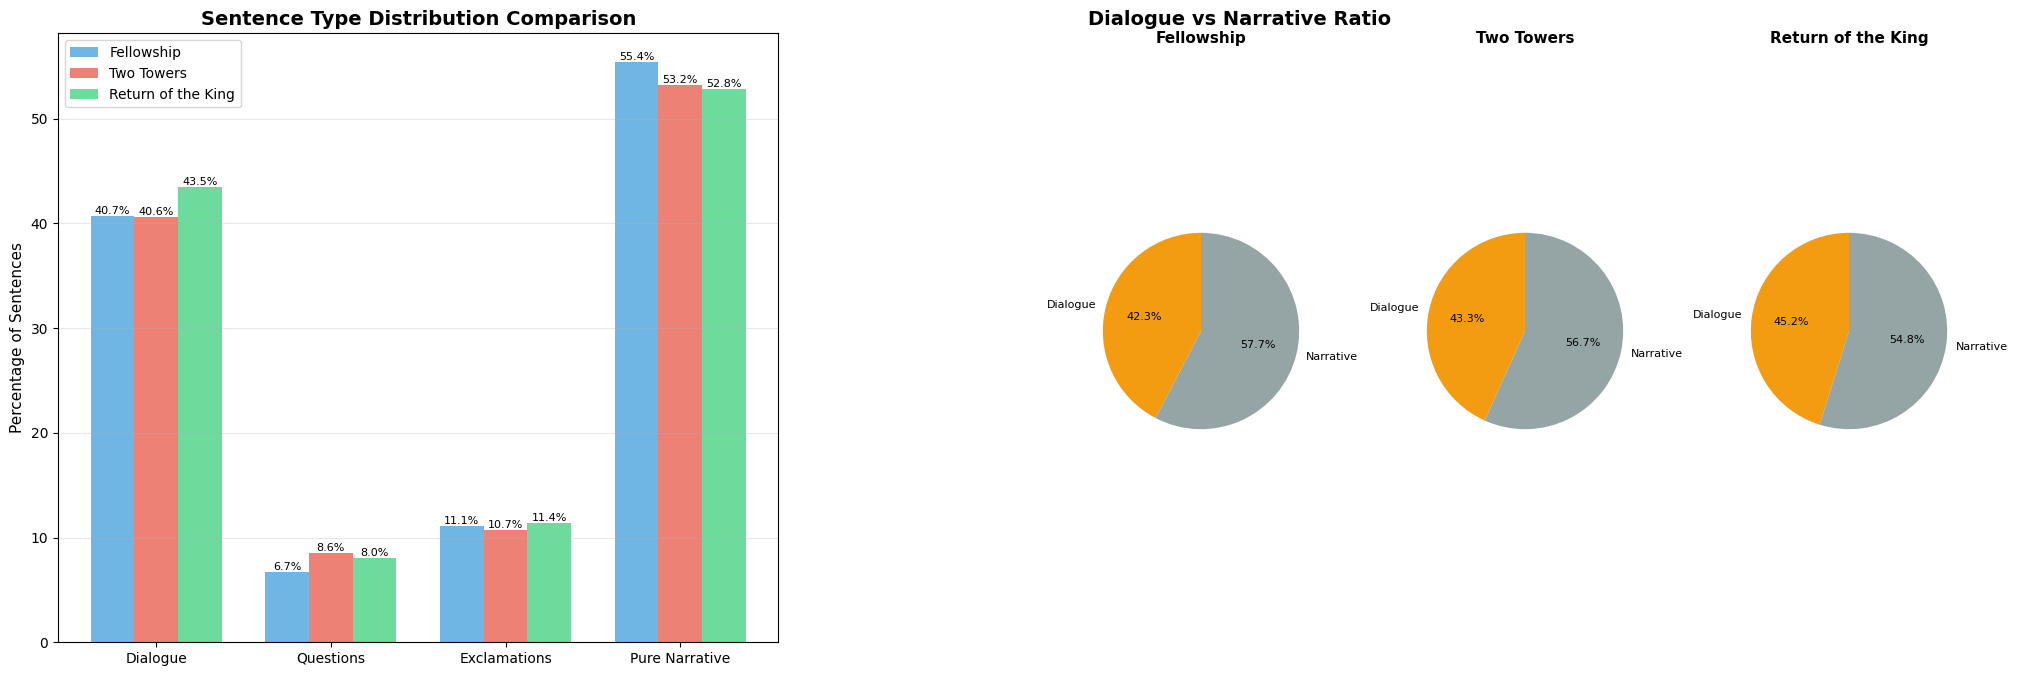

In [41]:
import pandas as pd

# Prepare data for all three books
categories = ['Dialogue', 'Questions', 'Exclamations', 'Pure Narrative']

data_sets = [stats1, stats2, stats3]
book_names = [CONFIG['book1_name'], CONFIG['book2_name'], CONFIG['book3_name']]
colors_bar = [TOLKIEN_COLORS[name] for name in book_names]

# Calculate percentage values for the bar chart
percentage_values = []
for stats in data_sets:
    total = stats['total']
    percentage_values.append([
        stats['dialogue'] / total * 100,
        stats['questions'] / total * 100,
        stats['exclamations'] / total * 100,
        stats['narrative'] / total * 100
    ])

# --- FIX: The data is now a (3, 4) array (Book, Category) ---
data_for_bar = np.array(percentage_values) 
x = np.arange(len(categories))
width = 0.25 # Bar width

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- Plot 1: Grouped Bar Chart ---
ax1 = axes[0]

# Plot bars for each book (data_for_bar[i] has shape (4,) which matches x's shape)
bars1 = ax1.bar(x - width, data_for_bar[0], width, label=book_names[0], color=colors_bar[0], alpha=0.7) # Book 1
bars2 = ax1.bar(x, data_for_bar[1], width, label=book_names[1], color=colors_bar[1], alpha=0.7)          # Book 2
bars3 = ax1.bar(x + width, data_for_bar[2], width, label=book_names[2], color=colors_bar[2], alpha=0.7) # Book 3

ax1.set_ylabel('Percentage of Sentences', fontsize=11)
ax1.set_title('Sentence Type Distribution Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

# --- Plot 2: Pie Charts for Dialogue Ratio (Dialogue vs Narrative) ---
ax2 = axes[1]
ax2.axis('off') # Hide the axis for the subplot container

# Create three sub-axes for the pie charts
from matplotlib.patches import Rectangle
pie_axes_inner = []

# Data for pie charts: [Dialogue, Narrative]
pie_data = [
    [stats1['dialogue'], stats1['narrative']],
    [stats2['dialogue'], stats2['narrative']],
    [stats3['dialogue'], stats3['narrative']],
]
pie_labels = ['Dialogue', 'Narrative']
pie_colors = ['#f39c12', '#95a5a6'] # Orange for Dialogue, Grey for Narrative
book_names = [CONFIG['book1_name'], CONFIG['book2_name'], CONFIG['book3_name']] # Define names for labels

# === FIX: Increased size and adjusted position/spacing ===
for i in range(3):
    # New positions: [left, bottom, width, height]
    # Increased width from 0.08 to 0.12, and increased spacing for separation
    ax_inner = fig.add_axes([0.61 + i * 0.18, 0.1, 0.12, 0.8]) 
    pie_axes_inner.append(ax_inner)

# Draw three pies
for i, ax_inner in enumerate(pie_axes_inner):
    ax_inner.set_title(book_names[i], fontsize=11, fontweight='bold')
    # Increased radius from 0.7 to 0.8 to fill the new, larger box
    ax_inner.pie(pie_data[i], labels=pie_labels, autopct='%1.1f%%', startangle=90, 
                 colors=pie_colors, textprops={'fontsize': 8}, radius=0.8)
    ax_inner.axis('equal') 
    ax_inner.set_aspect('equal')


# Set the main title for the pie chart area
ax2.set_title('Dialogue vs Narrative Ratio', fontsize=14, fontweight='bold', loc='center')
ax2.axis('off')

# Reposition the outer ax2 to prevent overlap (keep existing settings)
ax2.set_position([0.5, 0.1, 0.5, 0.8]) 

plt.tight_layout()
fig.savefig("../results/sentence_type_comparison.png", dpi=200, bbox_inches="tight")
plt.show()

In [38]:
import pandas as pd

# Create a dictionary for the DataFrame
stats_data = {
    'Metric': [
        'Total Sentences',
        'Dialogue Sentences',
        'Questions Sentences',
        'Exclamation Sentences',
        'Pure Narrative Sentences',
        'Dialogue Ratio (Percent)'
    ],
    CONFIG['book1_name']: [
        stats1['total'],
        stats1['dialogue'],
        stats1['questions'],
        stats1['exclamations'],
        stats1['narrative'],
        stats1['dialogue'] / stats1['total'] * 100
    ],
    CONFIG['book2_name']: [
        stats2['total'],
        stats2['dialogue'],
        stats2['questions'],
        stats2['exclamations'],
        stats2['narrative'],
        stats2['dialogue'] / stats2['total'] * 100
    ],
    CONFIG['book3_name']: [
        stats3['total'],
        stats3['dialogue'],
        stats3['questions'],
        stats3['exclamations'],
        stats3['narrative'],
        stats3['dialogue'] / stats3['total'] * 100
    ]
}

# Create and format the DataFrame
df_stats = pd.DataFrame(stats_data).set_index('Metric')

# Format for readability (using transposed view)
df_formatted = df_stats.T.style.format({
    'Total Sentences': '{:,.0f}',
    'Dialogue Sentences': '{:,.0f}',
    'Questions Sentences': '{:,.0f}',
    'Exclamation Sentences': '{:,.0f}',
    'Pure Narrative Sentences': '{:,.0f}',
    'Dialogue Ratio (Percent)': '{:,.2f}%'
})

print("\n" + "="*70)
print("DIALOGUE RATIO SUMMARY")
print("="*70)

# Save table to CSV
df_stats.to_csv("../results/sentence_type_stats.csv")
print("Saved stats table to ../results/sentence_type_stats.csv")

# Display the formatted table
df_formatted


DIALOGUE RATIO SUMMARY
Saved stats table to ../results/sentence_type_stats.csv


Metric,Total Sentences,Dialogue Sentences,Questions Sentences,Exclamation Sentences,Pure Narrative Sentences,Dialogue Ratio (Percent)
Fellowship,"10,533","4,285",702,"1,172","5,834",40.68%
Two Towers,"10,140","4,115",867,"1,090","5,398",40.58%
Return of the King,"7,200","3,134",578,818,"3,803",43.53%
